# PySpark构建回归模型
## 从数据中抽取合适的特征
[bike sharing](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)数据集记录bike sharing系统每小时自行车的出租次数，以及日期、天气、季节和节假日相关信息。
- instance:记录ID
- dteday:时间
- season:四季节信息
- yr:年份（2011或2012）
- mnth:月份
- hr:当天时刻
- holiday:是否是节假日
- weekday:周几
- workingday:当天是否是工作日
- weathersit:表示天气类型的参数
- temp:气温
- atemp:体感温度
- hum:湿度
- windspeed:风速
- cnt:目标变量，每小时的自行车租用量

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
!head -n 1 data/Bike-Sharing-Dataset/hour.csv

In [7]:
# first remove the headers by using the 'sed' command:
!sed 1d data/Bike-Sharing-Dataset/hour.csv > data/Bike-Sharing-Dataset/hour_noheader.csv

In [8]:
path = "data/Bike-Sharing-Dataset/hour_noheader.csv"
raw_data = sc.textFile(path)
num_data = raw_data.count()
records = raw_data.map(lambda x: x.split(","))
first = records.first()
print first
print num_data

[u'1', u'2011-01-01', u'1', u'0', u'1', u'0', u'0', u'6', u'0', u'1', u'0.24', u'0.2879', u'0.81', u'0', u'3', u'13', u'16']
17379


保留我们需要的变量，所有变量:
    instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt

需要保留的变量:

    season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt

函数get_mapping():
- 将idx列的特征去重
- 对每个值使用zipWithIndex()映射到一个唯一的索引，这样就组成了一个RDD的键值对，键是变量，值是索引

上述索引便是特征在二元向量中对应的非0位置。

In [9]:
# cache the dataset to speed up subsequent operations
records.cache()
# function to get the categorical feature mapping for a given variable column
def get_mapping(rdd, idx):
    return rdd.map(lambda fields: fields[idx]).distinct().zipWithIndex().collectAsMap()

# we want to extract the feature mappings for columns 2 - 9
# try it out on column 2 first
print "Mapping of first categorical feasture column: %s" % get_mapping(records, 2)

Mapping of first categorical feasture column: {u'1': 0, u'3': 1, u'2': 2, u'4': 3}


In [10]:
# extract all the catgorical mappings
mappings = [get_mapping(records, i) for i in range(2,10)]
cat_len = sum(map(len, mappings))
num_len = len(records.first()[11:15])
total_len = num_len + cat_len
print "Feature vector length for categorical features: %d" % cat_len 
print "Feature vector length for numerical features: %d" % num_len
print "Total feature vector length: %d" % total_len

Feature vector length for categorical features: 57
Feature vector length for numerical features: 4
Total feature vector length: 61


## 为线性模型创建特征向量
函数extract_features():
- 变量数据的每一行，根据已经创建的映射对每个特征进行二元编码。
- step变量用来确保非0特征在整个特征向量中位于正确的位置。
- 数值向量直接对之前已经被转成浮点数的数据用numpy的array封装。
- 最后将二元向量和数值向量拼接起来。

函数extract_label():将数据中最后一列cnt的数据转换成浮点数。

In [11]:
# required imports
from pyspark.mllib.regression import LabeledPoint
import numpy as np

# function to use the feature mappings to extract binary feature vectors, and concatenate with
# the numerical feature vectors
def extract_features(record):
    cat_vec = np.zeros(cat_len)
    i = 0
    step = 0
    for field in record[2:9]:
        m = mappings[i]
        idx = m[field]
        cat_vec[idx + step] = 1
        i = i + 1
        step = step + len(m)
    
    num_vec = np.array([float(field) for field in record[10:14]])
    return np.concatenate((cat_vec, num_vec))

# function to extract the label from the last column
def extract_label(record):
    return float(record[-1])

data = records.map(lambda r: LabeledPoint(extract_label(r), extract_features(r)))
first_point = data.first()
print "Raw data: " + str(first[2:])
print "Label: " + str(first_point.label)
print "Linear Model feature vector:\n" + str(first_point.features)
print "Linear Model feature vector length: " + str(len(first_point.features))

Raw data: [u'1', u'0', u'1', u'0', u'0', u'6', u'0', u'1', u'0.24', u'0.2879', u'0.81', u'0', u'3', u'13', u'16']
Label: 16.0
Linear Model feature vector:
[1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.24,0.2879,0.81,0.0]
Linear Model feature vector length: 61


## 为决策树创建特征向量
决策树模型可以直接使用原始数据（不需要将类型数据用二元向量表示）。因此，只需要创建一个分割函数简单地将所有数值转换为浮点数，最后用numpy的array封装：

In [12]:
# we need a separate set of feature vectors for the decision tree
def extract_features_dt(record):
    return np.array(map(float, record[2:14]))
    
data_dt = records.map(lambda r: LabeledPoint(extract_label(r), extract_features_dt(r)))
first_point_dt = data_dt.first()
print "Decision Tree feature vector: " + str(first_point_dt.features)
print "Decision Tree feature vector length: " + str(len(first_point_dt.features))

Decision Tree feature vector: [1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0]
Decision Tree feature vector length: 12


## 回归模型的训练和应用
### 在bike sharing数据上训练回归模型

In [23]:
from pyspark.mllib.regression import LinearRegressionWithSGD
linear_model = LinearRegressionWithSGD.train(data, iterations=10, step=0.1, intercept=False)
true_vs_predicted = data.map(lambda p: (p.label, linear_model.predict(p.features)))
print "Linear Model predictions: " + str(true_vs_predicted.take(5))

Linear Model predictions: [(16.0, 117.89250386724845), (40.0, 116.2249612319211), (32.0, 116.02369145779235), (13.0, 115.67088016754433), (1.0, 115.56315650834316)]


In [24]:
from pyspark.mllib.tree import DecisionTree
# we pass in an mepty mapping for categorical feature size {}
dt_model = DecisionTree.trainRegressor(data_dt, {})
preds = dt_model.predict(data_dt.map(lambda p: p.features))
actual = data.map(lambda p: p.label)
true_vs_predicted_dt = actual.zip(preds)
print "Decision Tree predictions: " + str(true_vs_predicted_dt.take(5))
print "Decision Tree depth: " + str(dt_model.depth())
print "Decision Tree number of nodes: " + str(dt_model.numNodes())

Decision Tree predictions: [(16.0, 54.913223140495866), (40.0, 54.913223140495866), (32.0, 53.171052631578945), (13.0, 14.284023668639053), (1.0, 14.284023668639053)]
Decision Tree depth: 5
Decision Tree number of nodes: 63


## 评估回归模型的性能
- MSE平方误差均值：$\sum_{i=1}^n{\frac{(w^Tx(i)-y(i))^2}{n}}$
- MAE平均绝对误差：$\sum_{i=1}^n\frac{|w^Tx(i)-y(i)|}{n}$
- RMSLE均方根对数误差
- R-平方系数

In [25]:
# set up performance metrics functions 

def squared_error(actual, pred):
    return (pred - actual)**2

def abs_error(actual, pred):
    return np.abs(pred - actual)

def squared_log_error(pred, actual):
    return (np.log(pred + 1) - np.log(actual + 1))**2

### 线性模型

In [26]:
# compute performance metrics for linear model
mse = true_vs_predicted.map(lambda (t, p): squared_error(t, p)).mean()
mae = true_vs_predicted.map(lambda (t, p): abs_error(t, p)).mean()
rmsle = np.sqrt(true_vs_predicted.map(lambda (t, p): squared_log_error(t, p)).mean())
print "Linear Model - Mean Squared Error: %2.4f" % mse
print "Linear Model - Mean Absolute Error: %2.4f" % mae
print "Linear Model - Root Mean Squared Log Error: %2.4f" % rmsle

Linear Model - Mean Squared Error: 30679.4539
Linear Model - Mean Absolute Error: 130.6429
Linear Model - Root Mean Squared Log Error: 1.4653


### 决策树

In [27]:
# compute performance metrics for decision tree model
mse_dt = true_vs_predicted_dt.map(lambda (t, p): squared_error(t, p)).mean()
mae_dt = true_vs_predicted_dt.map(lambda (t, p): abs_error(t, p)).mean()
rmsle_dt = np.sqrt(true_vs_predicted_dt.map(lambda (t, p): squared_log_error(t, p)).mean())
print "Decision Tree - Mean Squared Error: %2.4f" % mse_dt
print "Decision Tree - Mean Absolute Error: %2.4f" % mae_dt
print "Decision Tree - Root Mean Squared Log Error: %2.4f" % rmsle_dt

Decision Tree - Mean Squared Error: 11611.4860
Decision Tree - Mean Absolute Error: 71.1502
Decision Tree - Root Mean Squared Log Error: 0.6251


In [28]:
# we create the categorical feature mapping for decision trees
cat_features = dict([(i - 2, len(get_mapping(records, i)) + 1) for i in range(2,10)])
print "Categorical feature size mapping %s" % cat_features
# train the model again
dt_model_2 = DecisionTree.trainRegressor(data_dt, categoricalFeaturesInfo=cat_features)
preds_2 = dt_model_2.predict(data_dt.map(lambda p: p.features))
actual_2 = data.map(lambda p: p.label)
true_vs_predicted_dt_2 = actual_2.zip(preds_2)
# compute performance metrics for decision tree model
mse_dt_2 = true_vs_predicted_dt_2.map(lambda (t, p): squared_error(t, p)).mean()
mae_dt_2 = true_vs_predicted_dt_2.map(lambda (t, p): abs_error(t, p)).mean()
rmsle_dt_2 = np.sqrt(true_vs_predicted_dt_2.map(lambda (t, p): squared_log_error(t, p)).mean())
print "Decision Tree - Mean Squared Error: %2.4f" % mse_dt_2
print "Decision Tree - Mean Absolute Error: %2.4f" % mae_dt_2
print "Decision Tree - Root Mean Squared Log Error: %2.4f" % rmsle_dt_2

Categorical feature size mapping {0: 5, 1: 3, 2: 13, 3: 25, 4: 3, 5: 8, 6: 3, 7: 5}
Decision Tree - Mean Squared Error: 7912.5642
Decision Tree - Mean Absolute Error: 59.4409
Decision Tree - Root Mean Squared Log Error: 0.6192


从结果来看，决策树性能较好。

## 改进模型性能和参数调优
### 变更目标变量

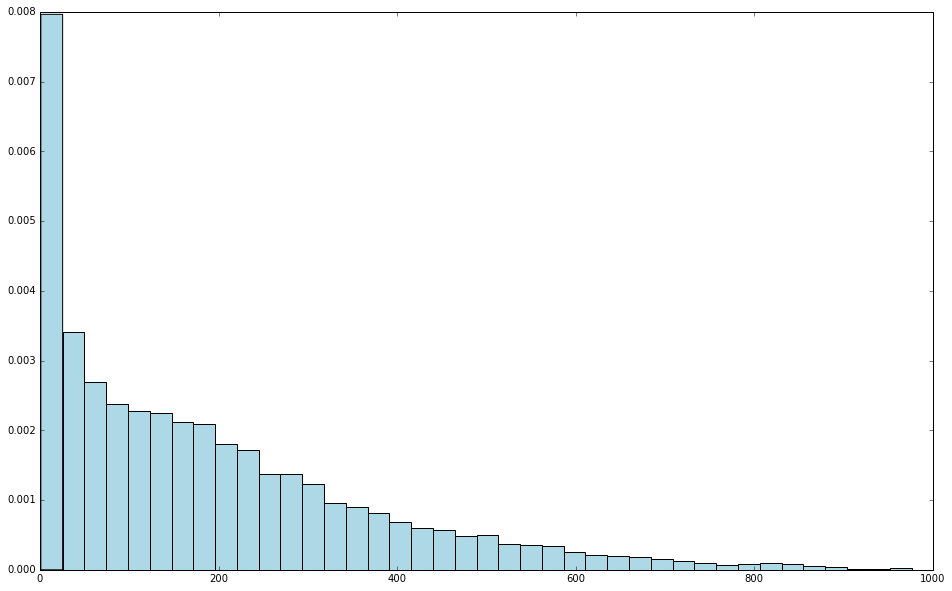

In [29]:
targets = records.map(lambda r: float(r[-1])).collect()
hist(targets, bins=40, color='lightblue', normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

线性模型假设输入数据和目标变量的分布为正态分布，上图是原始目标变量的分布直方图，可以看到其中的分布完全不符合正态分布。

一种办法是对目标变量进行变换。下面代码对所有的目标值进行对数变换，并画出对数变换后的直方图：

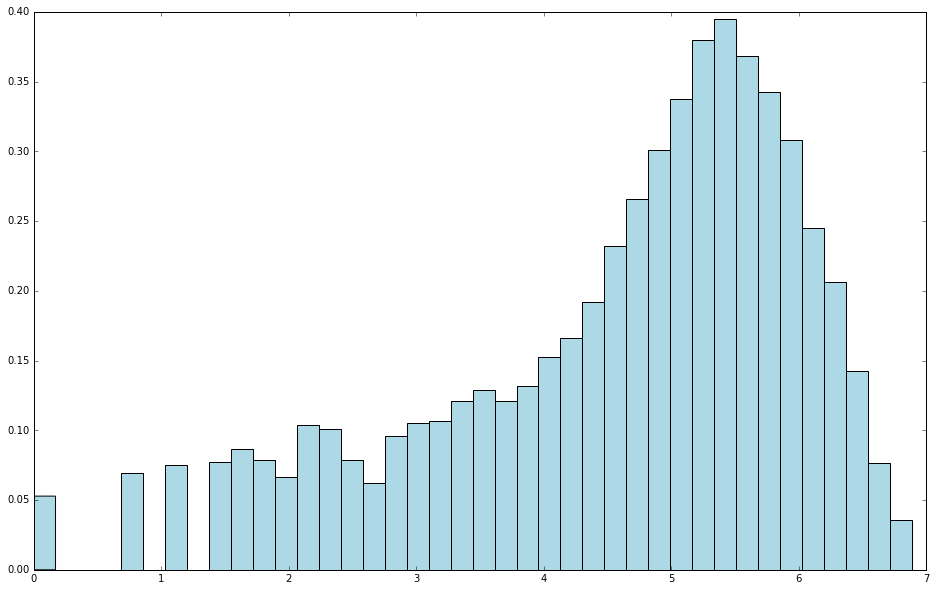

In [30]:
log_targets = records.map(lambda r: np.log(float(r[-1]))).collect()
hist(log_targets, bins=40, color='lightblue', normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

另一种变换是取平方根，适用于目标变量不为负数并且值域很大的情况。下面代码对所有的目标变量取平方根，然后画出相应的直方图：

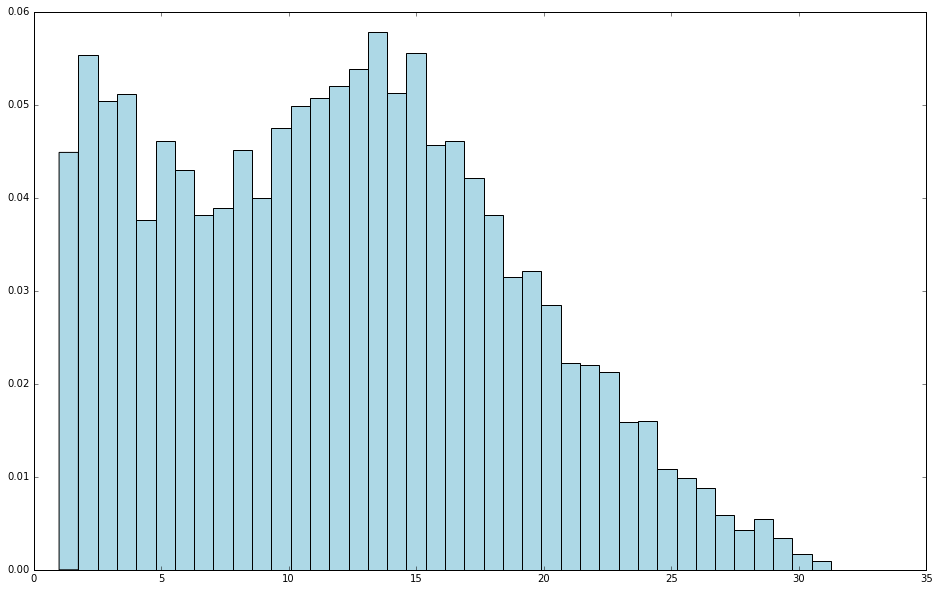

In [31]:
sqrt_targets = records.map(lambda r: np.sqrt(float(r[-1]))).collect()
hist(sqrt_targets, bins=40, color='lightblue', normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

In [32]:
# train a linear model on log-transformed targets
data_log = data.map(lambda lp: LabeledPoint(np.log(lp.label), lp.features))
model_log = LinearRegressionWithSGD.train(data_log, iterations=10, step=0.1)

true_vs_predicted_log = data_log.map(lambda p: (np.exp(p.label), np.exp(model_log.predict(p.features))))

mse_log = true_vs_predicted_log.map(lambda (t, p): squared_error(t, p)).mean()
mae_log = true_vs_predicted_log.map(lambda (t, p): abs_error(t, p)).mean()
rmsle_log = np.sqrt(true_vs_predicted_log.map(lambda (t, p): squared_log_error(t, p)).mean())
print "Mean Squared Error: %2.4f" % mse_log
print "Mean Absolute Error: %2.4f" % mae_log
print "Root Mean Squared Log Error: %2.4f" % rmsle_log
print "Non log-transformed predictions:\n" + str(true_vs_predicted.take(3))
print "Log-transformed predictions:\n" + str(true_vs_predicted_log.take(3))

Mean Squared Error: 50685.5559
Mean Absolute Error: 155.2955
Root Mean Squared Log Error: 1.5411
Non log-transformed predictions:
[(16.0, 117.89250386724845), (40.0, 116.2249612319211), (32.0, 116.02369145779235)]
Log-transformed predictions:
[(15.999999999999998, 28.080291845456223), (40.0, 26.959480191001774), (32.0, 26.654725629458007)]


In [33]:
# train a decision tree model on log-transformed targets
data_dt_log = data_dt.map(lambda lp: LabeledPoint(np.log(lp.label), lp.features))
dt_model_log = DecisionTree.trainRegressor(data_dt_log, {})

preds_log = dt_model_log.predict(data_dt_log.map(lambda p: p.features))
actual_log = data_dt_log.map(lambda p: p.label)
true_vs_predicted_dt_log = actual_log.zip(preds_log).map(lambda (t, p): (np.exp(t), np.exp(p)))

mse_log_dt = true_vs_predicted_dt_log.map(lambda (t, p): squared_error(t, p)).mean()
mae_log_dt = true_vs_predicted_dt_log.map(lambda (t, p): abs_error(t, p)).mean()
rmsle_log_dt = np.sqrt(true_vs_predicted_dt_log.map(lambda (t, p): squared_log_error(t, p)).mean())
print "Mean Squared Error: %2.4f" % mse_log_dt
print "Mean Absolute Error: %2.4f" % mae_log_dt
print "Root Mean Squared Log Error: %2.4f" % rmsle_log_dt
print "Non log-transformed predictions:\n" + str(true_vs_predicted_dt.take(3))
print "Log-transformed predictions:\n" + str(true_vs_predicted_dt_log.take(3))

Mean Squared Error: 14781.5760
Mean Absolute Error: 76.4131
Root Mean Squared Log Error: 0.6406
Non log-transformed predictions:
[(16.0, 54.913223140495866), (40.0, 54.913223140495866), (32.0, 53.171052631578945)]
Log-transformed predictions:
[(15.999999999999998, 37.530779787154508), (40.0, 37.530779787154508), (32.0, 7.2797070993907287)]


## Cross-validation
### 创建训练集和测试集
- 随机采样20%做测试集，剩下部分做训练集。

In [34]:
# create training and testing sets for linear model
data_with_idx = data.zipWithIndex().map(lambda (k, v): (v, k))
test = data_with_idx.sample(False, 0.2, 42)
train = data_with_idx.subtractByKey(test)

train_data = train.map(lambda (idx, p): p)
test_data = test.map(lambda (idx, p) : p)

train_size = train_data.count()
test_size = test_data.count()
print "Training data size: %d" % train_size
print "Test data size: %d" % test_size
print "Total data size: %d " % num_data
print "Train + Test size : %d" % (train_size + test_size)

Training data size: 13934
Test data size: 3445
Total data size: 17379 
Train + Test size : 17379


In [35]:
# create training and testing sets for decision tree
data_with_idx_dt = data_dt.zipWithIndex().map(lambda (k, v): (v, k))
test_dt = data_with_idx_dt.sample(False, 0.2, 42)
train_dt = data_with_idx_dt.subtractByKey(test_dt)

train_data_dt = train_dt.map(lambda (idx, p): p)
test_data_dt = test_dt.map(lambda (idx, p) : p)

### 参数设置对线性回归性能的影响
定义评估函数：

In [36]:
# create a function to evaluate linear model
def evaluate(train, test, iterations, step, regParam, regType, intercept):
    model = LinearRegressionWithSGD.train(train, iterations, step, regParam=regParam, regType=regType, intercept=intercept)
    tp = test.map(lambda p: (p.label, model.predict(p.features)))
    rmsle = np.sqrt(tp.map(lambda (t, p): squared_log_error(t, p)).mean())
    return rmsle

迭代次数和性能的变化：随着迭代次数的增加，误差确实有所下降，并且下降的速度和预期一样越来越小：

[1, 5, 10, 20, 50, 100]
[2.8779465130028199, 2.0390187660391499, 1.7761565324837874, 1.5828778102209107, 1.4382263191764473, 1.4050638054019446]


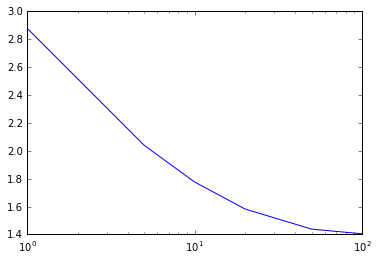

In [37]:
params = [1, 5, 10, 20, 50, 100]
metrics = [evaluate(train_data, test_data, param, 0.01, 0.0, 'l2', False) for param in params]
print params
print metrics
plot(params, metrics)
fig = matplotlib.pyplot.gcf()
pyplot.xscale('log')

步长变化对性能的影响：
- 默认步长1.0，得到的RMSLE结果为nan，说明SGD模型收敛到了最差的局部最优解。
- 通常较小的步长意味着收敛速度慢，需要较大的迭代次数。

[0.01, 0.025, 0.05, 0.1, 1.0]
[1.7761565324837874, 1.4379348243997032, 1.4189071944747715, 1.5027293911925559, nan]


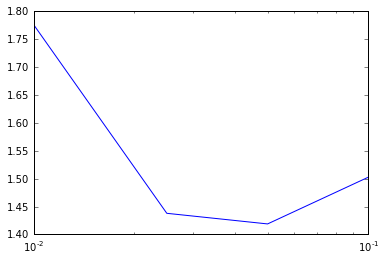

In [38]:
params = [0.01, 0.025, 0.05, 0.1, 1.0]
metrics = [evaluate(train_data, test_data, 10, param, 0.0, 'l2', False) for param in params]
print params
print metrics
plot(params, metrics)
fig = matplotlib.pyplot.gcf()
pyplot.xscale('log')

L2正则化（不同正则化参数下的性能）：

[0.0, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]
[1.5027293911925559, 1.5020646031965639, 1.4961903335175231, 1.4479313176192781, 1.4113329999970989, 1.5379824584440471, 1.8279564444985839]


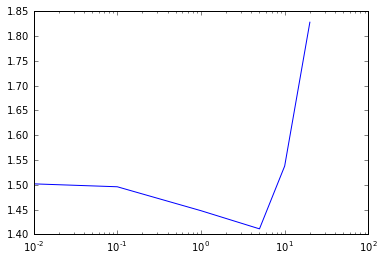

In [39]:
params = [0.0, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]
metrics = [evaluate(train_data, test_data, 10, 0.1, param, 'l2', False) for param in params]
print params
print metrics
plot(params, metrics)
fig = matplotlib.pyplot.gcf()
pyplot.xscale('log')

L1正则化（不同正则化参数下的性能）：
- L1正则化参数比L2要大，但是总体性能较差。
- 使用L1正则化可以得到稀疏的权重向量。

[0.0, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
[1.5027293911925559, 1.5026938950690176, 1.5023761634555699, 1.499412856617814, 1.4713669769550108, 1.7596682962964316, 4.7551250073268614]


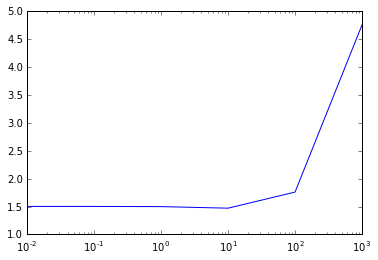

In [40]:
params = [0.0, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
metrics = [evaluate(train_data, test_data, 10, 0.1, param, 'l1', False) for param in params]
print params
print metrics
plot(params, metrics)
fig = matplotlib.pyplot.gcf()
pyplot.xscale('log')

In [41]:
# Investigate sparsity of L1-regularized solution
model_l1 = LinearRegressionWithSGD.train(train_data, 10, 0.1, regParam=1.0, regType='l1', intercept=False)
model_l1_10 = LinearRegressionWithSGD.train(train_data, 10, 0.1, regParam=10.0, regType='l1', intercept=False)
model_l1_100 = LinearRegressionWithSGD.train(train_data, 10, 0.1, regParam=100.0, regType='l1', intercept=False)
print "L1 (1.0) number of zero weights: " + str(sum(model_l1.weights.array == 0))
print "L1 (10.0) number of zeros weights: " + str(sum(model_l1_10.weights.array == 0))
print "L1 (100.0) number of zeros weights: " + str(sum(model_l1_100.weights.array == 0))

L1 (1.0) number of zero weights: 4
L1 (10.0) number of zeros weights: 33
L1 (100.0) number of zeros weights: 58


是否使用截距对性能影响：使用截距造成了RMSLE的值略微增加。

[False, True]
[1.4479313176192781, 1.4798261513419801]


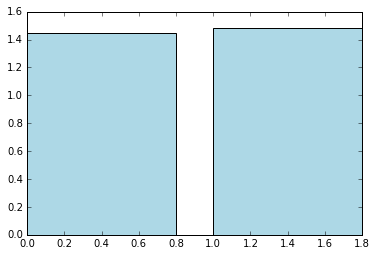

In [42]:
params = [False, True]
metrics = [evaluate(train_data, test_data, 10, 0.1, 1.0, 'l2', param) for param in params]
print params
print metrics
bar(params, metrics, color='lightblue')
fig = matplotlib.pyplot.gcf()

### 参数设置对决策树性能的影响

In [43]:
# create a function to evaluate decision tree model
def evaluate_dt(train, test, maxDepth, maxBins):
    model = DecisionTree.trainRegressor(train, {}, impurity='variance', maxDepth=maxDepth, maxBins=maxBins)
    preds = model.predict(test.map(lambda p: p.features))
    actual = test.map(lambda p: p.label)
    tp = actual.zip(preds)
    rmsle = np.sqrt(tp.map(lambda (t, p): squared_log_error(t, p)).mean())
    return rmsle

不同树深度下的性能：

[1, 2, 3, 4, 5, 10, 20]
[1.0280339660196287, 0.92686672078778276, 0.81807794023407532, 0.74060228537329209, 0.63583503599563096, 0.42630675767342086, 0.45134681265967197]


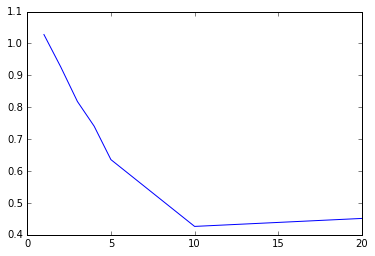

In [44]:
params = [1, 2, 3, 4, 5, 10, 20]
metrics = [evaluate_dt(train_data_dt, test_data_dt, param, 32) for param in params]
print params
print metrics
plot(params, metrics)
fig = matplotlib.pyplot.gcf()

不同的最大划分数目对性能的影响：

[2, 4, 8, 16, 32, 64, 100]
[1.3069788763726049, 0.81721457107308615, 0.75745322513058744, 0.65509498325812077, 0.63583503599563096, 0.63583503599563096, 0.63583503599563096]


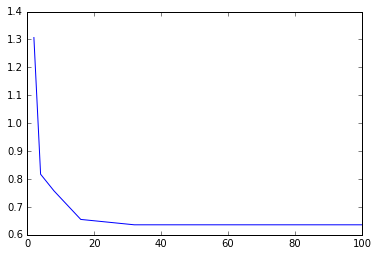

In [45]:
params = [2, 4, 8, 16, 32, 64, 100]
metrics = [evaluate_dt(train_data_dt, test_data_dt, 5, param) for param in params]
print params
print metrics
plot(params, metrics)
fig = matplotlib.pyplot.gcf()